# Random walk

In [1]:
# Load generated data from file:
import pickle

from evaluation import *

runs = []
num_chains = 10
for i in range(num_chains):
    with open(f"samples_produced/walk_model{i}__count1000_eps0.1_leapfrogsteps50.pickle", "rb") as f:
        runs.append(pickle.load(f))
with open(f"samples_produced/walk_is_10000000.pickle", "rb") as f:
    weighted_ground_truth, ground_truth = pickle.load(f)
thinned_ground_truth = ground_truth[::10]

In [2]:
# Read Anglican files:
for i in range(num_chains):
    for method in anglican_methods:
        runs[i][method] = {}
        with open(f"anglican_samples/rw/{method}{i}.txt") as f:
            contents = f.read()
            # Skip parentheses:
            contents = contents[1:-1]
            numbers = [float(x) for x in contents.split()]
            runs[i][method]["samples"] = numbers

# Read timings:
if anglican_methods:
    timings = parse_anglican_timings("anglican_samples/rw/timing.txt")
    for method in anglican_methods:
        for i in range(len(runs)):
            runs[i][method]["time"] = timings[method][i]

In [3]:
thinned_runs = thin_runs(all_methods, runs)
chains = collect_chains(all_methods, thinned_runs)
values = collect_values(all_methods, thinned_runs)
print_running_time(all_methods, runs, thinned_runs)


Running times:
hmc: 2266.38s    0.2266s per sample (after thinning)
is: 2448.00s    0.2448s per sample (after thinning)
lmh: 77.06s    0.0077s per sample (after thinning)
pgibbs: 51.44s    0.0051s per sample (after thinning)
rmh: 95.08s    0.0095s per sample (after thinning)
ipmcmc: 24.31s    0.0024s per sample (after thinning)


In [4]:
import numpyro.diagnostics as diag
import torch
import math

def ess_is(log_weights: list) -> float:
    log_weights = torch.tensor(log_weights)
    log_sum_of_squared = torch.logsumexp(2 * log_weights, dim=0)
    log_square_of_sum = 2 * torch.logsumexp(log_weights, dim=0)
    log_ess = log_square_of_sum - log_sum_of_squared
    return math.exp(log_ess.item())


print("Estimated effective sample sizes:")
for method in all_methods:
    min_size = min(len(chain) for chain in chains[method])
    trimmed_chains = [chain[:min_size] for chain in chains[method]]
    numpy = torch.tensor(trimmed_chains).numpy()
    print(f"{method}:  {diag.effective_sample_size(numpy):.1f}")
gt_log_weights = [w for (w, _) in weighted_ground_truth]
print(f"ground:  {ess_is(gt_log_weights):.1f} (by weights)")

Estimated effective sample sizes:
hmc:  6788.1
is:  9856.9
lmh:  5264.5
pgibbs:  3101.7
rmh:  5075.8
ipmcmc:  5015.6
ground:  437741.4 (by weights)


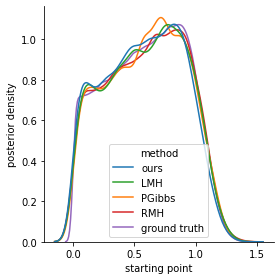

In [5]:
# Plot the Anglican data
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

data = []
for method in compared_methods:
    data += [(method_name[method], v) for v in values[method]]
data += [("ground truth", v) for v in thinned_ground_truth]
x_label = "starting point"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    kind="kde",
    common_norm=False,
    facet_kws={"legend_out": False},
    palette=palette,
    aspect=1,
    height=4,
)
plot.set_ylabels(label="posterior density")
plot.savefig("walk-kde.pdf", bbox_inches="tight")

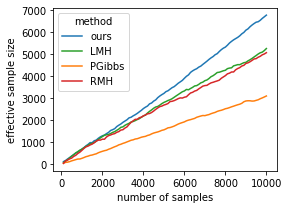

In [6]:
# graph effective sample size:
import pandas
from tqdm import tqdm

ess_data = []
for method in compared_methods:
    min_size = min(len(chain) for chain in chains[method])
    trimmed_chains = [chain[:min_size] for chain in chains[method]]
    np_chains = torch.tensor(trimmed_chains).numpy()
    num_chains, num_samples = np_chains.shape
    for i in range(1, 101):
        n = i * num_samples // 100
        ess = diag.effective_sample_size(np_chains[:, :n]).item()
        ess_data.append((method_name[method], n * num_chains, ess))
df = pandas.DataFrame(ess_data, columns=["method", "number of samples", "effective sample size"])
plt.figure(figsize=(4,3))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="effective sample size",
    hue="method",
    palette=palette,
)
plot.get_figure().savefig("walk-ess-plot.pdf", bbox_inches="tight")

In [7]:
# Load Pyro data:
import pickle

pyro_hmc_runs = []
pyro_nuts_runs = []
num_chains = 10
for i in range(num_chains):
    with open(f"samples_produced/walk_model{i}_pyro_hmc{i}_count1000_eps0.1_steps50.pickle", "rb") as f:
        pyro_hmc_runs.append(pickle.load(f))
    with open(f"samples_produced/walk_model{i}_pyro_nuts{i}_count1000.pickle", "rb") as f:
        pyro_nuts_runs.append(pickle.load(f))

In [8]:
import numpyro.diagnostics as diag

print("Estimated ESS:")
print(f"Pyro HMC:\t{diag.effective_sample_size(torch.tensor(pyro_hmc_runs).numpy()):.1f}")
print(f"Pyro NUTS:\t{diag.effective_sample_size(torch.tensor(pyro_nuts_runs).numpy()):.1f}")

Estimated ESS:
Pyro HMC:	nan
Pyro NUTS:	892.8


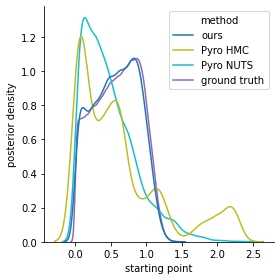

In [9]:
# Plot the data
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

pyro_hmc_samples = sum(pyro_hmc_runs, [])
pyro_nuts_samples = sum(pyro_nuts_runs, [])
data = (
    [("ours", v) for v in values["hmc"]]
    + [("Pyro HMC", v) for v in pyro_hmc_samples]
    + [("Pyro NUTS", v) for v in pyro_nuts_samples]
    + [("ground truth", v) for v in thinned_ground_truth]
)
x_label = "starting point"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    kind="kde",
    common_norm=False,
    facet_kws={"legend_out": False},
    palette=palette,
    aspect=1,
    height=4,
)
plot.set_ylabels(label="posterior density")
plot.savefig("walk-pyro-kde.pdf", bbox_inches="tight")